# Milestone 2 - Adavengers 2023

In this milestone, we will get acquainted with the data, preprocess it and do necessary descriptive statistics tasks. We will also plan our future analysis in detail and describe, as well as test, proposed methodologies.

In [72]:
#This can be deleted later:
#Idea for structure of this Milestone 2 Notebook:
#Step 1: Importing Data
#Step 2: Cleaning Data - remove Nans, PAY ATTENTION TO DUPLICATES!
#Step 3: Descriptive Statistics - how is data distributed, what are mean values,... 
#Step 4: Getting into details of adjectives topic (if we get that far): 
    #test how we can identify adjectives 
    #and who if a sentence is about male or female
#Step 5: maybe start answering our other research questions, if we have time!

In [73]:
#QUESTIONS general:
#should we merge everything to one df? probably, right?

In [4]:
#Library Imports
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from statsmodels.stats import diagnostic


## Step 1: Importing the Data

In [5]:
#metadata_headers = ["Wikipedia_ID", "Freebase_ID", "Movie name" , "Movie release date", "box_office_revenue", "Movie runtime", "Movie languages","Movie countries", "Movie genres"]
metadata_headers = ["Wikipedia_ID", "Freebase_ID", "Movie_name" , "Release_date", "box_office_revenue", "runtime", "languages","countries", "genres"]
dfmetadata = pd.read_csv('data/movie.metadata.tsv',sep='\t',header =None, names =metadata_headers)
#dfmetadata.head()

#Reading in the Data
#dfsummaries=pd.read_table('data/plot_summaries.txt',header=None,names=["Wikipedia_ID","Summary"])
dfsummaries=pd.read_table('data/plot_summaries.txt',header=None,names=["Wikipedia_ID","Summary"])
#dfsummaries.head()
character_head = ["Wikipedia_ID","Freebase_ID", "Release_date", "Character_name", "Actor_date_of_birth", "Gender", "Height", "Ethnicity", "Actor_name", "Age","Freebase_character/actor_map_ID", "Freebase_character_ID", "Freebase_actor_ID"]
dfcharacter =pd.read_csv('data/character.metadata.tsv',sep='\t',header =None, names =character_head)

## Step 2 A: Cleaning Summaries Data

In [6]:
#Checking if the Wikipedia_IDs in summaries are the same as in Metadata by randomly checking an id (31186339)
print(dfsummaries[dfsummaries["Wikipedia_ID"]==31186339]["Summary"])
print(dfmetadata[dfmetadata["Wikipedia_ID"]==31186339]["Movie_name"]) 

1    The nation of Panem consists of a wealthy Capi...
Name: Summary, dtype: object
78373    The Hunger Games
Name: Movie_name, dtype: object


In [7]:
#Checking if there are NaNs
print(dfsummaries["Wikipedia_ID"].hasnans) #There are no NaNs.
print(dfsummaries["Summary"].hasnans) #There are no NaNs.

False
False


In [8]:
#Checking if there are double entries and removing them
print(dfsummaries["Wikipedia_ID"].is_unique) #This is true, nice!
print(dfsummaries["Summary"].is_unique) #This is false
dfsummaries.drop_duplicates(['Summary'],inplace=True)
print(dfsummaries["Summary"].is_unique) 
#Now we can see there are no more duplicates (remember to do same for metadata!)

True
False
True


In [9]:
#Another thing we could do is look at the type of the data. 
#The IDs should all be positive integers, the summaries all str.
dfsummaries.dtypes #We can see that this is the case

Wikipedia_ID     int64
Summary         object
dtype: object

In [10]:
#Checking if we have negative values for ID
dfsummaries["Wikipedia_ID"].min() #Nice! They're all positive.

330

## Step 2 B Describing Summaries Data

In [11]:
#Checking how many entries there are
print("number of summary entries:",len(dfsummaries))
print("number of metadata entries:",len(dfmetadata)) 
#We can see that there is not a summary for every movie but only about half.

number of summary entries: 42295
number of metadata entries: 81741


In [12]:
#Check the lengths of the summaries (we can see that there is a great spread.)
dfsummaries["Summary_Length"]=dfsummaries['Summary'].apply(lambda x: len(x))
print("The length of summaries ranges from %d to %d characters." %(dfsummaries["Summary_Length"].min(),dfsummaries["Summary_Length"].max()))

The length of summaries ranges from 99 to 28159 characters.


<Axes: >

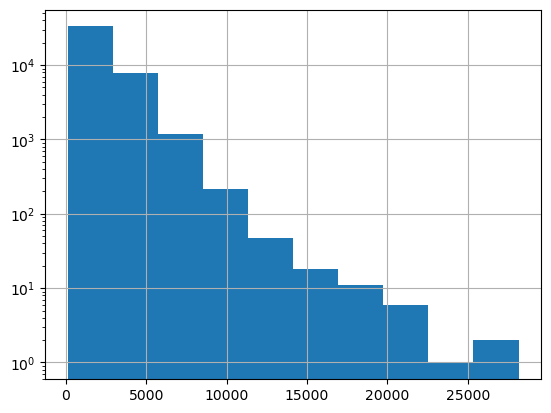

In [13]:
#Displayed in a logarithmic histogram, we can see that most movie summaries are short and a few are bigger.
dfsummaries["Summary_Length"].hist(log=True)

In [14]:
#So, how are the summary lengths actually distributed? Let's find out
print(diagnostic.kstest_normal(dfsummaries['Summary_Length'].values, dist = 'norm'))
print(diagnostic.kstest_normal(dfsummaries['Summary_Length'].values, dist = 'exp'))
#P-avlue < 0.05. The summary lengths are neither normal nor exponentially dist

(0.17600314066454867, 0.0009999999999998899)
(0.0571594944628687, 0.0009999999999998899)


There are some summaries much longer than others. Though for now we do the learning on the whole summary dataset as if it was a huge text. This might lead to a bias that the word embedding will learn more from movies with a bigger summary length than those with a shorter. An hypothesis we have is that maybe the longest summaries are the most watched movies and thus the most representative of how the bias between men and women might be seen by the general public of people watching movies. To chech this let'sdo a scatter plot with box office thinking that movies with most data are the most watched movies.

## Step 3A Cleaning Metadata

In [15]:
dfmetadata.head()

,Wikipedia_ID,Freebase_ID,Movie_name,Release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [16]:
dfmetadata.dtypes

Wikipedia_ID            int64
Freebase_ID            object
Movie_name             object
Release_date           object
box_office_revenue    float64
runtime               float64
languages              object
countries              object
genres                 object
dtype: object

In [17]:
#Just from looking at the Data we can already see that there are some NaNs 
#in the office box revenue. Let's see how many
print(dfmetadata["Wikipedia_ID"].hasnans)

False


In [18]:
dfmetadata.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Wikipedia_ID        81741 non-null  int64  
 1   Freebase_ID         81741 non-null  object 
 2   Movie_name          81741 non-null  object 
 3   Release_date        74839 non-null  object 
 4   box_office_revenue  8401 non-null   float64
 5   runtime             61291 non-null  float64
 6   languages           81741 non-null  object 
 7   countries           81741 non-null  object 
 8   genres              81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


In [19]:
(len(dfmetadata)-dfmetadata["box_office_revenue"].isna().sum()) /len(dfmetadata)
#We can see that we only have box office revenue values for around 10% of the movie data!

0.1027758407653442

We can see that there are some NaNs for the release date and the runtime. Especially, there seem to be alot of NaNs for box office revenue!
This is important as it might affect the feasibility of answering the question if the amount of women in a movie has an effect on box office revenue. We thus decided to not explore further this research question. 

### Step 4A : cleaning character data

First let's have a quick look at the data.

In [20]:
dfcharacter.head()

,Wikipedia_ID,Freebase_ID,Release_date,Character_name,Actor_date_of_birth,Gender,Height,Ethnicity,Actor_name,Age,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [21]:
dfcharacter.describe()

,Wikipedia_ID,Height,Age
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


In [22]:
dfcharacter.columns

Index(['Wikipedia_ID', 'Freebase_ID', 'Release_date', 'Character_name',
       'Actor_date_of_birth', 'Gender', 'Height', 'Ethnicity', 'Actor_name',
       'Age', 'Freebase_character/actor_map_ID', 'Freebase_character_ID',
       'Freebase_actor_ID'],
      dtype='object')

#### Height
We see that the maximum height is 510 which doesn't make sense. We look at the characters with a height above 2m75 as it is the height of the tallest person registered on the guinness world records.

In [23]:
display(dfcharacter[dfcharacter.Height>2.75])

,Wikipedia_ID,Freebase_ID,Release_date,Character_name,Actor_date_of_birth,Gender,Height,Ethnicity,Actor_name,Age,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
21619,1291587,/m/04qk12,2004-09-01,young Georgie,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,18.0,/m/0k276dx,/m/0k276dz,/m/0bggwvl
49659,30865068,/m/02ml14,1998-10-15,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0n9ld0y,NaN,/m/08hqh0
59719,12206655,/m/02vvw24,NaN,Dominic,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,NaN,/m/0k276dq,/m/0h8hcr1,/m/0bggwvl
104140,17999628,/m/047n_2q,1998,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,25.0,/m/0cg31bd,NaN,/m/08hqh0
205679,1373475,/m/04xmx8,2003-08-15,Jackal Johnson,1972-12-06,M,510.0,NaN,Vince Corazza,30.0,/m/02vbm0k,/m/0h60xk7,/m/08hqh0
219383,179326,/m/018gq3,1996-11-18,Herbert,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,10.0,/m/0bggwv8,/m/0bggwvc,/m/0bggwvl
301653,4667507,/m/0cg9n6,2001-11-29,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,28.0,/m/0cg0zwp,NaN,/m/08hqh0
316621,3915041,/m/0b6lyp,2002,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,29.0,/m/02vc5p5,NaN,/m/08hqh0
341890,29290087,/m/0b3w9mr,1997-04-07,NaN,1972-12-06,M,510.0,NaN,Vince Corazza,24.0,/m/0gvwy8x,NaN,/m/08hqh0
360967,14413223,/m/03d2rnl,2012-04-20,Young Punk Guy,1986-03-13,M,180.0,/m/0dc58y8,Zohren Weiss,26.0,/m/0m4q87d,/m/0k9tfs8,/m/0bggwvl


We notice that most values for height are in meters and somes are in centimeters and some are of 510. However there are only 15 outliers above 2.75 which are mostly the same actors. We considered changing Zohren Weiss height to 1m80 but as we don't find on internet there true height to check if it was this we are just going to remove it. Moreover we probably won't use Height so we just change the values to Nan.

In [24]:
dfcharacter.loc[:,["Height"]] = dfcharacter.loc[:,["Height"]].mask(dfcharacter["Height"] >2.75)
dfcharacter.Height.describe()

count    154809.000000
mean          1.748177
std           0.106249
min           0.610000
25%           1.676400
50%           1.750000
75%           1.830000
max           2.356000
Name: Height, dtype: float64

#### Age 

We notice negative age which doesn't make sense. When we check on the imbd it correspond to error in the birth date entry thus we transform the age and the birth date to Nan when negative values are found.

In [25]:
dfcharacter.loc[:,["Age","Actor_date_of_birth"]] = dfcharacter.loc[:,["Age","Actor_date_of_birth"]].mask(dfcharacter["Age"] <0)
dfcharacter.Age.describe()

count    292175.000000
mean         37.890901
std          14.085909
min           0.000000
25%          28.000000
50%          36.000000
75%          47.000000
max         103.000000
Name: Age, dtype: float64

The minimum age is now at 0 which corresponds to baby born this year so we are happy. Let's now groupby gender to check whether there are differences between the genders in the data that can be cofounders in our analysis.

#### Difference between genders

In [26]:
Grouped_gender = dfcharacter.groupby("Gender")
Grouped_gender.Age.describe()

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,99124.0,32.956055,13.376106,0.0,24.0,30.0,40.0,99.0
M,191277.0,40.469717,13.749781,0.0,31.0,39.0,49.0,103.0


F         Axes(0.1,0.15;0.363636x0.75)
M    Axes(0.536364,0.15;0.363636x0.75)
dtype: object

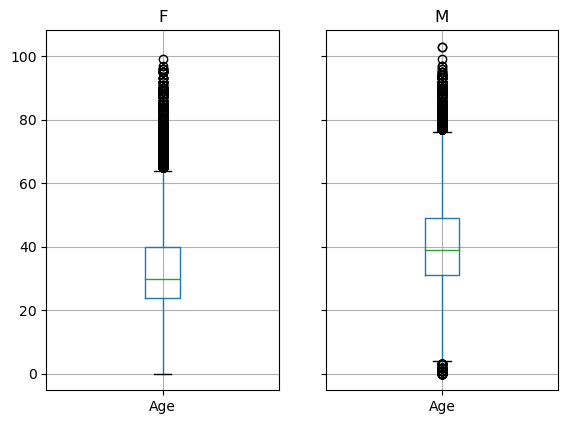

In [27]:
Grouped_gender.boxplot(column = ["Age"])

We observe a difference between male and female age let's see if it's statistically significant.

In [29]:
ttest_ind( dfcharacter.loc[dfcharacter['Gender'] == "M", 'Age'].dropna(),dfcharacter.loc[dfcharacter['Gender'] == "F", 'Age'].dropna())

Ttest_indResult(statistic=140.92509242040052, pvalue=0.0)

The p-value is lower than 0.05 thus we can reject the null hypothesis that the two distributions have the same mean. The statistics is positive thus we can say than in average man actors are older than women. We need to keep this information in mind when we analyze the adjectives as women are younger than men in average because younger people can be described with different adjectives than older people.

### Merging summaries and movie datasets

In [30]:
movie_merged = dfmetadata.merge(dfsummaries,how ='outer')
movie_merged["summary_presence"] = (~movie_merged["Summary"].isna()).astype(int)

Let's see if the dataset with summaries is representative of the actual movie dataset.

In [31]:
summary_and_movie = movie_merged.groupby("summary_presence")

In [32]:
summary_and_movie.runtime.describe()

,count,mean,std,min,25%,50%,75%,max
summary_presence,,,,,,,,
0,25715.0,88.681832,129.330496,0.0,71.0,90.0,101.0,14400.0
1,35576.0,128.543294,5721.781337,0.3,86.0,96.0,110.0,1079281.0


We notice that there are very short movies. What do we do with this movie are 

In [34]:
ttest_ind(movie_merged.loc[movie_merged['summary_presence'] == 1, 'runtime'].dropna(),movie_merged.loc[movie_merged['summary_presence'] == 0, 'runtime'].dropna())

Ttest_indResult(statistic=1.1169508863229334, pvalue=0.2640197039395456)

The runtime however is not statistically different between the two populations. Anyway do we say they don't have an impact on populations as long movies that are more main streams. Probably shorter movies are more representative of old movies.

Let's look if the movies with summary are representative of the movies the most watched. By looking at the box office revenue.

In [35]:
summary_and_movie.box_office_revenue.describe()

,count,mean,std,min,25%,50%,75%,max
summary_presence,,,,,,,,
0,814.0,1.289109e+07,3.912451e+07,10000.0,776601.75,2000000.0,7704827.0,5.525261e+08
1,7587.0,5.175973e+07,1.167179e+08,10200.0,2500000.00,12421181.0,45597223.0,2.782275e+09


We notice that there are much more movies when summaries are in the dataset. Furthermore the the box office revenue is mainly higher for movies with a summary. Let's see if it's statistically significant.

In [39]:
ttest_ind(movie_merged.loc[movie_merged['summary_presence'] == 1, 'box_office_revenue'].dropna(),movie_merged.loc[movie_merged['summary_presence'] == 0, 'box_office_revenue'].dropna())

Ttest_indResult(statistic=9.443907873081669, pvalue=4.5670654197868206e-21)

The p-value is lower than 0.5 thus we can exclude the null hypothesis that the movie with a summary and the movies without follow the same distribution for box-office revenue. 

#### Cleaning cluster data

We were thinking of using this to look at a possible link between female character rate and box office performance? And which types of female characters historically correlate with higher box office success?
However we said earlier that we don't have lots of data on box office. For the personas clusters the dataset is quite small as well thus we probably continue on this research question because of the lack of data. However we cleaned it in case we still decide to use the cluster data for small analysis.

In [41]:
#We can see that the infos about character, movie, id and actor are all in one column.
df_clusters_initial=pd.read_table('data/tvtropes.clusters.txt',header=None)
df_clusters_initial

,0,1
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."
...,...,...
496,young_gun,"{""char"": ""Morgan Earp"", ""movie"": ""Tombstone"", ..."
497,young_gun,"{""char"": ""Colorado Ryan"", ""movie"": ""Rio Bravo""..."
498,young_gun,"{""char"": ""Tom Sawyer"", ""movie"": ""The League of..."
499,young_gun,"{""char"": ""William H. 'Billy the Kid' Bonney"", ..."


In [42]:
#The infos are stored in string representations of dictionaries
example_entry = df_clusters_initial[1][1]
print(type(example_entry))

<class 'str'>


In [43]:
#We need to turn the string representations of dictionaries into actual dictionaries
#(The if statement is just so the cell can be run without having run the previous cells, to avoid confusion)
import ast
if type(example_entry)==str: 
    df_clusters_initial[1]=df_clusters_initial[1].apply(lambda x: ast.literal_eval(x))

In [45]:
#Now, we can separate the values in the dictionaries to different columns
df_dict = pd.json_normalize(df_clusters_initial[1])

In [46]:
#Adding the separated dictionary values to the initial df
dfclusters = pd.concat([df_clusters_initial.drop(1,axis=1), df_dict], axis=1)

In [47]:
dfclusters=dfclusters.rename(columns={0:"type",'actor':'Actor_name','id':'Freebase_character/actor_map_ID'})
dfclusters

,type,char,movie,Freebase_character/actor_map_ID,Actor_name
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton
497,young_gun,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez


In order to see which character types are more commonly females and which males we have to merge this with the character metadata dataframe

In [49]:
#We only need the info on genders from the character df so I do this to avoid having to drop many columns later
dfcharacter_genders = dfcharacter[['Freebase_character/actor_map_ID', 'Gender']]

#Adding gender info to clusters data
clusters_merged = dfclusters.merge(dfcharacter_genders,on="Freebase_character/actor_map_ID")